# Explore pyiron-like workflows

Aim: Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [1]:
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

In [2]:
%%time
from pyiron_atomistics.atomistics.structure.atoms import Atoms

CPU times: user 3.24 s, sys: 522 ms, total: 3.77 s
Wall time: 3.79 s


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Create structure and list available potentials

In [4]:
wf = Workflow('Lammps')
wf.register('atomistics', 'pyiron_workflow.node_library.atomistics')
wf.register('lammps', 'pyiron_workflow.node_library.lammps')
wf.register('atomistic_codes', 'pyiron_workflow.node_library.atomistic_codes')
wf.register('pyiron_atomistics', 'pyiron_workflow.node_library.pyiron_atomistics')

In [5]:
wf = Workflow('Lammps')
wf.structure = wf.create.pyiron_atomistics.Bulk('Al', cubic=True)
wf.repeat = wf.create.lammps.Repeat(structure = wf.structure, repeat_scalar=1)

wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
wf.lammps.ListPotentials()[:5]

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

In [6]:
wf.draw(depth=2);

In [7]:
out = wf.run()
print (f'Potential energy: {wf.lammps.outputs.generic.value.energy_pot[0]}')

Potential energy: -13.4399999882896


### MD over list of temperatures

T= 300
T= 600
T= 900
CPU times: user 229 ms, sys: 83.6 ms, total: 313 ms
Wall time: 2.15 s


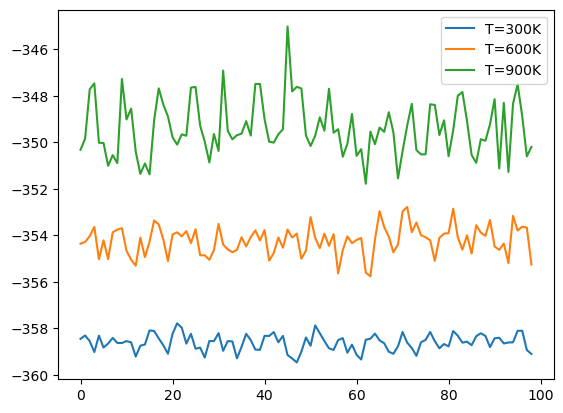

In [8]:
%%time
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    wf.structure = wf.create.pyiron_atomistics.Bulk('Al', cubic=True)
    wf.repeat = wf.create.lammps.Repeat(structure = wf.structure, repeat_scalar=3)
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
    wf.lammps.calc_select.md(temperature=T, n_ionic_steps=10_000)
    print ('T=', wf.lammps.calc.inputs.temperature)
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energy_pot[2:], label=f'T={T}K')
plt.legend();    

In [9]:
wf.draw(depth=2);

In [10]:
wf.lammps.draw();

### Murnaghan (E-V) macro

In [11]:
# volumes = wf.create.standard.Linspace(0.9, 1.1, 11)

In [12]:
@Workflow.wrap_as.macro_node()
def energy_at_volume(wf) -> None:
    wf.bulk = wf.create.pyiron_atomistics.Bulk('Al', cubic=True)
    wf.repeat = wf.create.lammps.Repeat(structure = wf.bulk, repeat_scalar=1)
    wf.apply_strain = wf.create.lammps.ApplyStrain(structure=wf.repeat, strain=1)
    
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.apply_strain, label='lammps')
    
    wf.inputs_map = {
        "bulk__name": "element",
        "apply_strain__strain": "strain",
        "lammps__potential__name": "potential",
    }
    wf.outputs_map = {"lammps__Potential__generic": "generic"}

In [13]:
#wf.create.iter(energy_at_volume, strain=wf.create.numpy.linspace(-0.2, 0.2, 11))

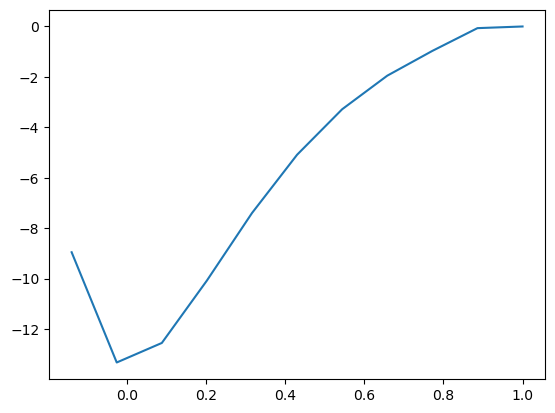

In [14]:
import numpy as np

energy_pot = []
strain_lst = np.linspace(0.86, 2, 11) - 1
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out['lammps__generic'].energy_pot[0])  

plt.plot(strain_lst, energy_pot);

In [15]:
wf.outputs.lammps__generic.value

### Data store

In [16]:
from pyiron_workflow.node_library.dev_tools import DataStore, node_to_data_container, extract_value

In [17]:
ds = DataStore(path='DataStore')
ds.store(wf, overwrite=True)

True

In [18]:
wf_new = ds.load(wf.label)

In [19]:
wf.lammps

TODO: Convert data_container to node

In [20]:
out = wf(element='Fe')

In [21]:
ds.remove(wf.label)

node energy_at_volume has been removed from store


#### Test pickle

In [22]:
import  cloudpickle as pickle

In [23]:
with open('node.pickle', 'wb') as f:
    pickle.dump(wf, f)

In [24]:
with open('node.pickle', 'rb') as f:
    new_node = pickle.load(f)

In [25]:
new_node.run();

In [26]:
new_node.outputs.lammps__generic.value.energy_pot

array([0])

In [27]:
out.lammps__generic.energy_pot

array([0])

In [28]:
del out['lammps__ListPotentials__potentials']

In [29]:
out

{'lammps__Shell__output': <pyiron_workflow.node_library.lammps.ShellOutput at 0x156c585d0>,
 'lammps__generic': <pyiron_workflow.node_library.lammps.GenericOutput at 0x156b31490>}

## Apply Jan's atomist class

In [30]:
wf.create.atomistics

{'calculator': {'CalcWithCalculator': abc.CalcWithCalculator,
  'Abinit': abc.Abinit,
  'Emt': abc.Emt,
  'Gpaw': abc.Gpaw,
  'Lammps': abc.Lammps,
  'LammpsPotential': abc.LammpsPotential,
  'QuantumEspresso': abc.QuantumEspresso,
  'Siesta': abc.Siesta},
 'macro': {'ElasticMatrix': abc.ElasticMatrix,
  'EnergyVolumeCurve': abc.EnergyVolumeCurve,
  'Phonons': abc.Phonons},
 'task': {'AnalyseStructures': abc.AnalyseStructures,
  'GenerateStructures': abc.GenerateStructures,
  'Bulk': abc.Bulk,
  'ElasticMatrixTaskGenerator': abc.ElasticMatrixTaskGenerator,
  'EvcurveTaskGenerator': abc.EvcurveTaskGenerator,
  'PhononsTaskGenerator': abc.PhononsTaskGenerator}}

In [31]:
wf = Workflow('Murnaghan')
wf.bulk = wf.create.atomistics.task.Bulk('Al', cubic=True)
wf.lammps = wf.create.atomistics.calculator.Lammps()
wf.lammps_potential = wf.create.atomistics.calculator.LammpsPotential(structure=wf.bulk)
wf.macro = wf.create.atomistics.macro.EnergyVolumeCurve(calculator=wf.lammps)

In [32]:
bulk = wf.bulk.run()
bulk

Atoms(symbols='Al', pbc=True, cell=[[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

In [33]:
wf.lammps_potential.inputs

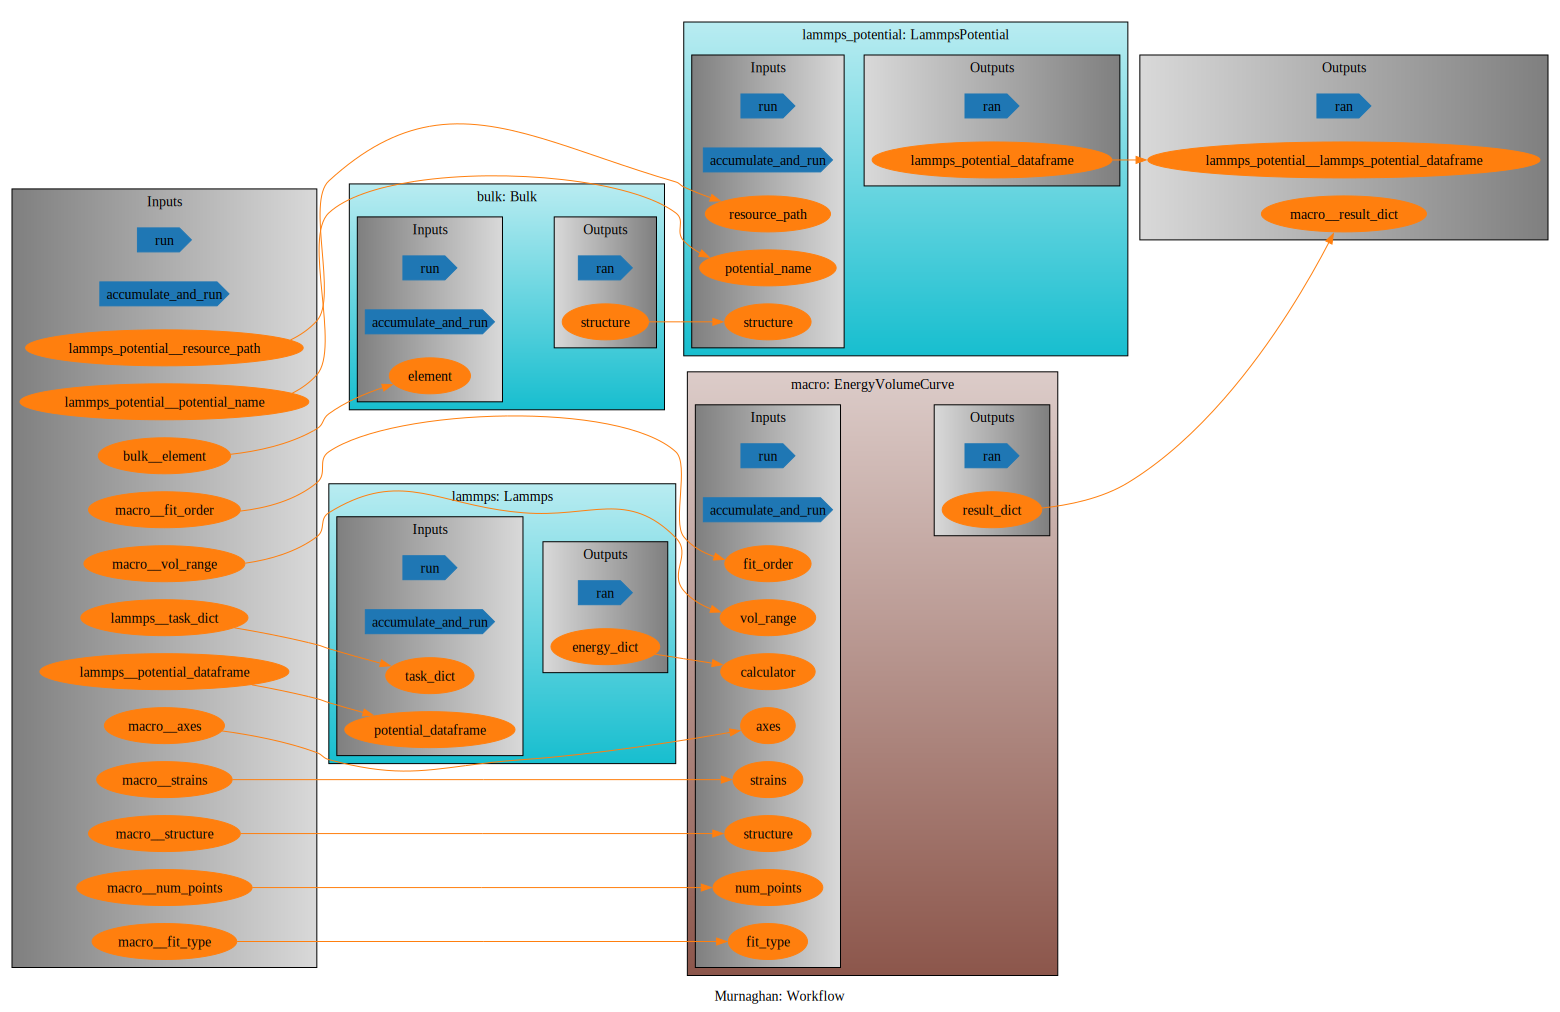

In [34]:
wf.draw()